In [159]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset
import csv
from PIL import Image
import re
from torchsummary import summary

cudnn.benchmark = True
plt.ion()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dataset

In [160]:
class CustomDataset(Dataset):
    def __init__(self, path, transform=None):
        super().__init__()
        self.transform = transform
        self.main_dir = os.path.join(path)
        self.all_imgs = sorted(os.listdir(self.main_dir), key=lambda s: int(re.search(r'\d+', s).group()))
        
    def __len__(self):
        return len(self.all_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

Device

In [161]:
#apple
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#windows
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mps


Load Data

In [162]:

data_transforms =  transforms.Compose([
        transforms.Resize((512,512)),
        transforms.ToTensor(),
    ])
directory = os.getcwd()
data_dir = '/Users/nayansavaliya/Desktop/AnomalyDetection/data/transistor/train/good'
train_dataset = CustomDataset(data_dir,data_transforms)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                             shuffle=False, num_workers=0)

val_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                             shuffle=False, num_workers=0)

print(len(train_dataloader),len(val_dataloader))

43 11


View Data

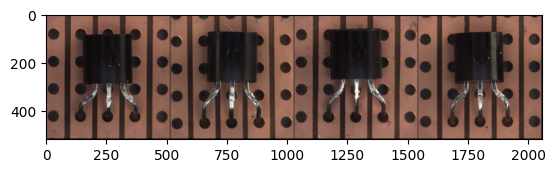

In [163]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of  data
inputs = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

Datasets & DataLoaders

In [164]:
image_datasets = {'train': train_dataset }
dataloaders = {'train': train_dataloader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}


Encoder

In [165]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(256*13*13, 2),
            nn.ReLU(True),
        )    
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 256*13*13),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(256, 13, 13)),
            nn.ConvTranspose2d(256, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 4, 2, 1, bias=False),
            nn.ReLU(True)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        x = self.encoder(x)
        return x
    

In [166]:
testModel = AutoEncoder()
summary(testModel, (3, 512, 512),4)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [4, 8, 256, 256]             384
       BatchNorm2d-2           [4, 8, 256, 256]              16
              ReLU-3           [4, 8, 256, 256]               0
            Conv2d-4          [4, 16, 128, 128]           2,048
       BatchNorm2d-5          [4, 16, 128, 128]              32
              ReLU-6          [4, 16, 128, 128]               0
            Conv2d-7            [4, 32, 64, 64]           8,192
       BatchNorm2d-8            [4, 32, 64, 64]              64
              ReLU-9            [4, 32, 64, 64]               0
           Conv2d-10            [4, 64, 32, 32]          32,768
      BatchNorm2d-11            [4, 64, 32, 32]             128
             ReLU-12            [4, 64, 32, 32]               0
           Conv2d-13           [4, 128, 16, 16]         131,072
      BatchNorm2d-14           [4, 128,

Model, Loss & Optimizer

In [167]:
torch.manual_seed(0)

loss = torch.nn.MSELoss()
lr= 0.0001

model = AutoEncoder()
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-05)

model.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

Train

In [168]:
def train_epoch(model, device, dataloader, loss_fn, optimizer):

    model.train()
    train_loss = []
    for image_batch in dataloader: 
        image_batch = image_batch.to(device)
        decoded_data = model(image_batch)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

Validation Test

In [169]:
def test_epoch(model, device, dataloader, loss_fn):
    model.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch in dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model(image_batch)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

Plot Output

In [170]:
def plot_ae_outputs(model,n=10):
  inputs = next(iter(val_dataloader))
  out = torchvision.utils.make_grid(inputs)
  imshow(out)
  img = inputs.to(device)
  model.eval()
  with torch.no_grad():
      rec_img  = model(img)
  rec_img = rec_img.cpu()
  rec_out =  torchvision.utils.make_grid(rec_img)
  imshow(rec_out)

Training

	 partial train loss (single batch): 0.104811
	 partial train loss (single batch): 0.099291
	 partial train loss (single batch): 0.098541
	 partial train loss (single batch): 0.099696
	 partial train loss (single batch): 0.087004
	 partial train loss (single batch): 0.091243
	 partial train loss (single batch): 0.092215
	 partial train loss (single batch): 0.085487
	 partial train loss (single batch): 0.088040
	 partial train loss (single batch): 0.085976
	 partial train loss (single batch): 0.085091
	 partial train loss (single batch): 0.091943
	 partial train loss (single batch): 0.090329
	 partial train loss (single batch): 0.082746
	 partial train loss (single batch): 0.090030
	 partial train loss (single batch): 0.084979
	 partial train loss (single batch): 0.083862
	 partial train loss (single batch): 0.085559
	 partial train loss (single batch): 0.083448
	 partial train loss (single batch): 0.085271
	 partial train loss (single batch): 0.084914
	 partial train loss (single batch

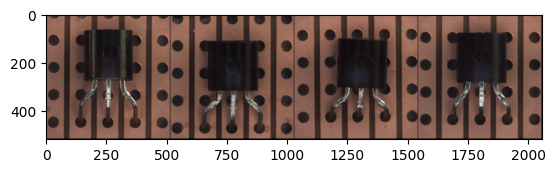

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


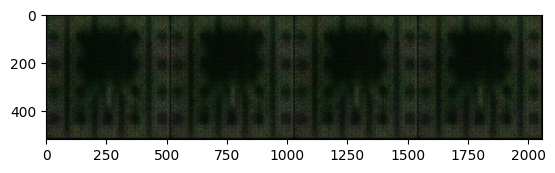

	 partial train loss (single batch): 0.074360
	 partial train loss (single batch): 0.073700
	 partial train loss (single batch): 0.075765
	 partial train loss (single batch): 0.078661
	 partial train loss (single batch): 0.067968
	 partial train loss (single batch): 0.072283
	 partial train loss (single batch): 0.073030
	 partial train loss (single batch): 0.067766
	 partial train loss (single batch): 0.070361
	 partial train loss (single batch): 0.069341
	 partial train loss (single batch): 0.068942
	 partial train loss (single batch): 0.075600
	 partial train loss (single batch): 0.073264
	 partial train loss (single batch): 0.066940
	 partial train loss (single batch): 0.073518
	 partial train loss (single batch): 0.070083
	 partial train loss (single batch): 0.069267
	 partial train loss (single batch): 0.070018
	 partial train loss (single batch): 0.068391
	 partial train loss (single batch): 0.070011
	 partial train loss (single batch): 0.069648
	 partial train loss (single batch

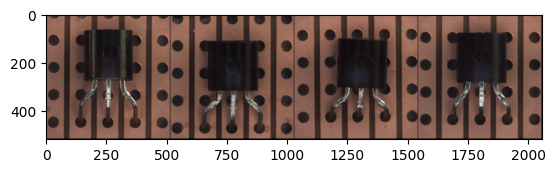

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


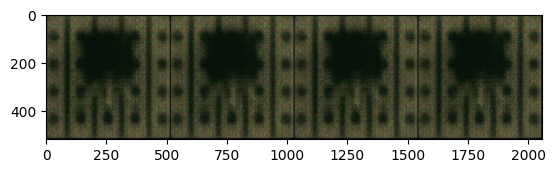

	 partial train loss (single batch): 0.061706
	 partial train loss (single batch): 0.061329
	 partial train loss (single batch): 0.063115
	 partial train loss (single batch): 0.065595
	 partial train loss (single batch): 0.056575
	 partial train loss (single batch): 0.060237
	 partial train loss (single batch): 0.060451
	 partial train loss (single batch): 0.056383
	 partial train loss (single batch): 0.058549
	 partial train loss (single batch): 0.058066
	 partial train loss (single batch): 0.057891
	 partial train loss (single batch): 0.063596
	 partial train loss (single batch): 0.060831
	 partial train loss (single batch): 0.055666
	 partial train loss (single batch): 0.061345
	 partial train loss (single batch): 0.059034
	 partial train loss (single batch): 0.058264
	 partial train loss (single batch): 0.058416
	 partial train loss (single batch): 0.057251
	 partial train loss (single batch): 0.058617
	 partial train loss (single batch): 0.058250
	 partial train loss (single batch

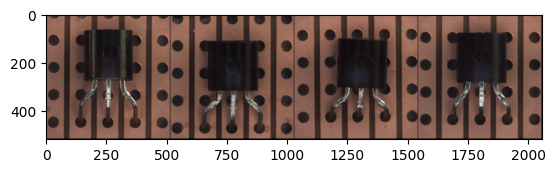

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


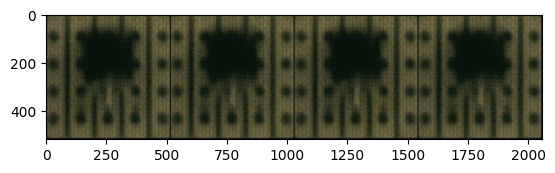

	 partial train loss (single batch): 0.051623
	 partial train loss (single batch): 0.051418
	 partial train loss (single batch): 0.052976
	 partial train loss (single batch): 0.055050
	 partial train loss (single batch): 0.047298
	 partial train loss (single batch): 0.050388
	 partial train loss (single batch): 0.050180
	 partial train loss (single batch): 0.047010
	 partial train loss (single batch): 0.048777
	 partial train loss (single batch): 0.048564
	 partial train loss (single batch): 0.048501
	 partial train loss (single batch): 0.053385
	 partial train loss (single batch): 0.050371
	 partial train loss (single batch): 0.046008
	 partial train loss (single batch): 0.050909
	 partial train loss (single batch): 0.049344
	 partial train loss (single batch): 0.048502
	 partial train loss (single batch): 0.048281
	 partial train loss (single batch): 0.047436
	 partial train loss (single batch): 0.048574
	 partial train loss (single batch): 0.048086
	 partial train loss (single batch

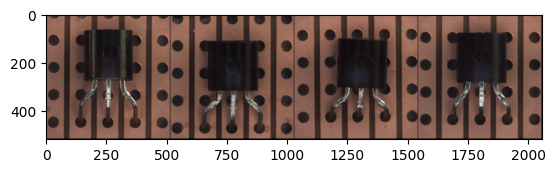

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


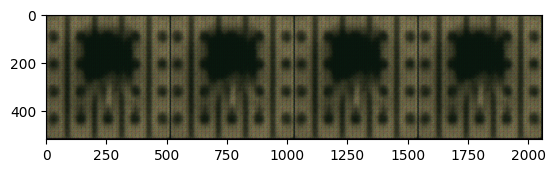

	 partial train loss (single batch): 0.042341
	 partial train loss (single batch): 0.042318
	 partial train loss (single batch): 0.043742
	 partial train loss (single batch): 0.045409
	 partial train loss (single batch): 0.038987
	 partial train loss (single batch): 0.041404
	 partial train loss (single batch): 0.040868
	 partial train loss (single batch): 0.038474
	 partial train loss (single batch): 0.039934
	 partial train loss (single batch): 0.040075
	 partial train loss (single batch): 0.040085
	 partial train loss (single batch): 0.044350
	 partial train loss (single batch): 0.041082
	 partial train loss (single batch): 0.037538
	 partial train loss (single batch): 0.041682
	 partial train loss (single batch): 0.040941
	 partial train loss (single batch): 0.040097
	 partial train loss (single batch): 0.039463
	 partial train loss (single batch): 0.038970
	 partial train loss (single batch): 0.039815
	 partial train loss (single batch): 0.039436
	 partial train loss (single batch

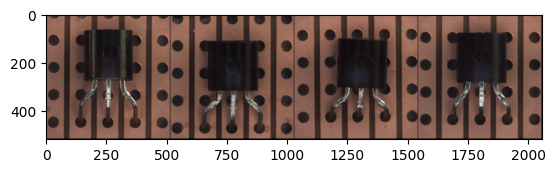

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


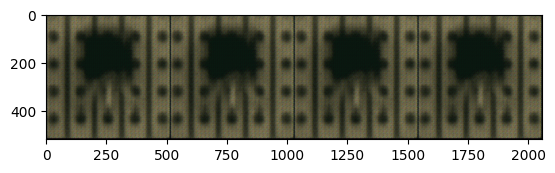

In [171]:
num_epochs = 5
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(model,device,train_dataloader,loss,optim)
   val_loss = test_epoch(model,device,val_dataloader,loss)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(model,n=10)

Temp Section do not delete

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 512, 512])


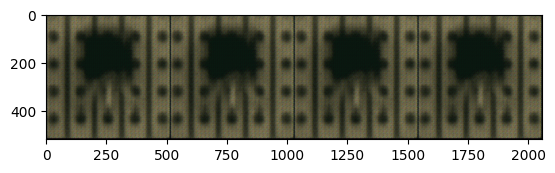

In [172]:
inputs = next(iter(train_dataloader))
inputs = inputs.to(device)
out = model(inputs)
print(out.shape)
out = out.cpu()
out = torchvision.utils.make_grid(out)
out =  out.detach()
imshow(out)

In [178]:
with torch.no_grad():
        conc_out = []
        for image_batch in val_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            conc_out.append(decoded_data.cpu())
        conc_out = torch.cat(conc_out)
print(conc_out)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
